#  Interacting with diffuse light attenuation coefficients (kd)
**Author:** Ryan Vandermeulen (NOAA)</br>
Last updated: October 16, 2025

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/kd_vizualization.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Workshop_Hub-green?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/kd_vizualization.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/kd_vizualization.ipynb
[jupyter-link]: https://workshop.nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/kd_vizualization.ipynb

## You should select 3.8 Gb RAM when you start the server

## Introduction to kd

We often think of remote sensing products as largely representative of near-surface values. For the most part, this is true. With ocean color, we're essentially looking at an integrated signal of light emerging from the ocean. The differential depths at which light disappears is a function of how turbid the water is, which, in turn, impacts how much an individual wavelength of light contributes to the remote sensing reflectance that we see from space. Let's follow the story of a little photon of light with a bit more detail.

First, let's call "light" out by its preferred terminology in this context - spectral downwelling irradiance just below the sea surface, $E_{s}^{-}({\lambda})$, a term that represents the amount of light at each wavelength that has hit the surface of the ocean and crossed over the air-sea barrier. From here, $E_{s}^{-}({\lambda})$ is attenuated (i.e., disappeared) exponentially with depth ($z$). PACE now provides the slope of this exponential decay function, known as the diffuse light attenuation coefficient, $K_{d}({\lambda})$, for 19 individual wavelengths. Thus, at any given depth of the ocean, we can determine the spectral downwelling irradiance, $E_{d}({\lambda},z)$, as follows:

$$
E_{d}({\lambda},z) = E_{s}^{-}({\lambda})*exp^{-Kd*z}
$$

If we are supplied a standard reference $E_{s}^{-}({\lambda})$ spectrum, a $K_{d}({\lambda})$ value from PACE, and a depth of our choice, we can solve for $E_{d}({\lambda},z)$ and figure out how much and what kind of light is available at any given depth, anywhere in the ocean. In other words, a 3D product! Well, 4D I guess, if we consider latitude, longitude, wavelengths, and depth. If this is a bit fuzzy, not to worry, we'll illustrate this concept a bit more in the following exercises.

>📘 Learning Objectives
>
> 1. Create a global map of the downwelling light attenuation coefficient product from PACE
> 2. Create a depth profile showing the variation of spectral downwelling irradiance 
> 3. Create a spectral plot of downwelling irradiance showing the changes in light quality with depth
> 4. Create a pretty cross-section plot illustrating the difference in light penetration for two different areas

## *Are you ready?*

If you are on the JupyterHub, all packages are installed. If you are on Colab, there are a couple packages you need.


In [1]:
# If you are on Colab uncomment this and run first to install packages
#!pip install earthaccess cartopy hvplot

## A standard, run-of-the-mill rainbow

Where do bad rainbows go? (They go to Prism) They get a light sentence though, it's only so they can have time to reflect...

...

...

Right. First thing, we need a reference spectrum. As mentioned above, this is spectral downwelling irradiance just below the sea surface, $E_{s}^{-}({\lambda})$. If you're interested in the details, this was calculated from the ASTM G173-03 Reference Spectra Derived from SMARTS v. 2.9.2, additionally corrected for an average sun angle for satellites, diffuse contributions, and crossing the air-sea boundary. We have entered the reference data into a data frame for you.
<!--
# Create the one-liner for the es spectrum from the file
with open("Es_spectrum.csv", "r") as f:
    lines = f.read().splitlines()

csv_inline = "\\n".join(lines)
print(f'import pandas as pd; from io import StringIO\n\ndf_es = pd.read_csv(StringIO("{csv_inline}"))')
-->

In [1]:
import pandas as pd; from io import StringIO
df_es = pd.read_csv(StringIO("wave,Es\n351,0.43348\n361,0.43439\n385,0.47793\n413,0.92794\n425,0.93371\n442,1.0603\n460,1.1661\n475,1.1853\n490,1.1524\n510,1.1682\n532,1.1506\n555,1.1472\n583,1.1366\n618,1.0676\n640,1.0623\n655,0.96797\n665,1.0384\n678,1.0291\n711,0.96479"))
df_es

,wave,Es
0,351,0.43348
1,361,0.43439
2,385,0.47793
3,413,0.92794
4,425,0.93371
5,442,1.06030
6,460,1.16610
7,475,1.18530
8,490,1.15240
9,510,1.16820


Just in case you like to see what this looks like so it's not some abstract concept, let's take a quick look. This is a quantified representation of the sun's intensity of light at different wavelengths, after passing through the atmosphere and sitting at the top surface layer of ocean water. We're getting a little fancy with the rainbow colors, but it helps illustrate the point. Refer to the commented out portion for a simpler representation. 

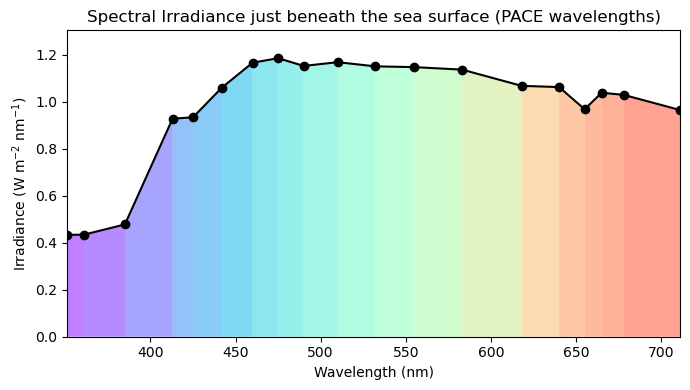

In [2]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np

# Normalize wavelengths for color mapping; df_es is the Es data we loaded above
norm = plt.Normalize(df_es['wave'].min(), df_es['wave'].max())
colors = plt.cm.rainbow(norm(df_es['wave'].iloc[:-1]))

# Build colored polygon segments
verts = [
    [(w1, 0), (w1, e1), (w2, e2), (w2, 0)]
    for (w1, e1), (w2, e2) in zip(df_es[['wave', 'Es']].values[:-1], df_es[['wave', 'Es']].values[1:])
]

poly = PolyCollection(verts, facecolors=colors, alpha=0.5)

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.add_collection(poly)
ax.plot(df_es['wave'], df_es['Es'], 'k-o', label='Es')  # overlay line

ax.set_xlim(df_es['wave'].min(), df_es['wave'].max())
ax.set_ylim(0, df_es['Es'].max() * 1.1)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Irradiance (W m$^{-2}$ nm$^{-1}$)')
ax.set_title('Spectral Irradiance just beneath the sea surface (PACE wavelengths)')
plt.tight_layout()
plt.show()

## Get the PACE data from NASA Earthdata

### Authenticate

In [3]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

### Search for data

Load the monthly Level 3 Kd data.

In [4]:
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD",
    temporal = ("2024-09-01", "2024-09-30"),
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

1

There are fancy ways of finding the "short_name" above, but if you're not familiar with them and in a hurry, find your dataset here: <https://www.earthdata.nasa.gov/data/catalog?keyword=PACE%20OCI&platforms_h[0][basis]=Space-based%20Platforms&science_keywords_h[0][topic]=Oceans>

### Load the data

In [5]:
# Create a fileset
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# load the dataset
import xarray as xr
dataset = xr.open_dataset(fileset[0])
dataset

<xarray.Dataset> Size: 441MB
Dimensions:     (wavelength: 17, lat: 1800, lon: 3600, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 136B 400.0 413.0 425.0 ... 678.0 701.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Kd          (lat, lon, wavelength) float32 441MB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240901_20240930.L3m.MO.KD.V...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/KD/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3435953
    data_minimum:                      0.0014
    data_maximum:                      5.999

We can see it has coordinates wavelength, lat and lon and variables Kd and palette.

## Plotting

In [7]:
# ---- Load Libraries for printing ----
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gc

# ---- Create a coarsen function to speed up plotting
# subsample the lat/lons. We don't need to show all
def coarsen_da(da, step=2):
    return da.isel(lat=slice(None, None, step),
                   lon=slice(None, None, step))

### Create a Kd map

Let’s start by choosing a single wavelength, and making a map of Kd from PACE. 490 nm is a “heritage” color band that has been used as a standard for multispectral satellite missions. This plot is RAM hungry since it is loading in all the data.

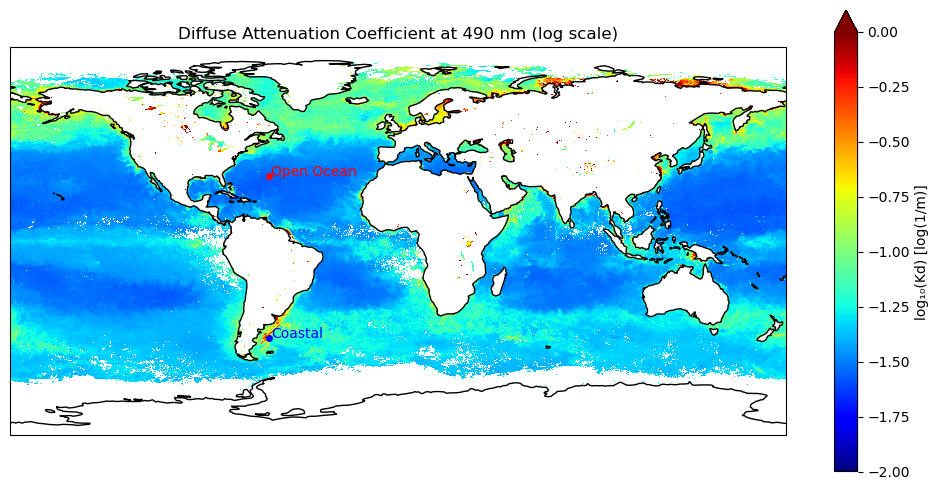

In [8]:
# Extract and clean the Kd value at 490 nm
Kd_490 = dataset["Kd"].sel(wavelength=490.0)
Kd_490_clean = Kd_490.where(Kd_490 > 0)
Kd_log = np.log10(Kd_490_clean)
Kd_log = coarsen_da(Kd_log, step=4) # subset lat/lon for faster plotting

# Plot using xarray's built-in .plot() with Cartopy
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
Kd_log.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='jet',
    vmin=-2,
    vmax=0,
    cbar_kwargs={'label': 'log₁₀(Kd) [log(1/m)]'}
)
ax.coastlines()
ax.set_title('Diffuse Attenuation Coefficient at 490 nm (log scale)')

# Plot points for open and coastal points
open_coord = {'lat': 30.0, 'lon': -60.0}
coastal_coord = {'lat': -45.0, 'lon': -60.0}
ax.plot(open_coord['lon'], open_coord['lat'], 'ro', markersize=4, transform=ccrs.PlateCarree())
ax.text(open_coord['lon'] + 1, open_coord['lat'], 'Open Ocean', color='red', transform=ccrs.PlateCarree())
ax.plot(coastal_coord['lon'], coastal_coord['lat'], 'bo', markersize=4, transform=ccrs.PlateCarree())
ax.text(coastal_coord['lon'] + 1, coastal_coord['lat'], 'Coastal', color='blue', transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()


Lower Kd values = lower rate of light attenuation = light goes deeper into the water

Higher Kd values = more rapid attenuation of light = light doesn't go as deep

We can do the plot with `hvplot` to make an interactive plot that we can zoom into. `hvplot` is RAM efficient. It only loads a coarsened version of the full dataset and then loads the finer scale data as we zoom in. Click on the map and you can zoom in. The tooltip will show the lat/lon and Kd.

In [9]:
import xarray as xr
import hvplot.xarray  # activates hvplot access on xarray objects
import hvplot.pandas
import numpy as np
import pandas as pd
import holoviews as hv
from holoviews import opts
import cartopy.feature as cfeature

hv.extension('bokeh')

# Extract and lazily clean Kd(490)
Kd_490 = dataset["Kd"].sel(wavelength=490.0)
Kd_clean = Kd_490.where(Kd_490 > 0)
Kd_log = np.log10(Kd_clean)

# Create base plot
kd_plot = Kd_log.hvplot.image(
    x='lon',
    y='lat',
    cmap='jet',
    clim=(-2, 0),
    colorbar=True,
    frame_width=800,         # explicitly set
    frame_height=400,        # explicitly set
    title='log₁₀(Kd) at 490 nm',
    rasterize=True,
    coastline=True,
)

# set text size
kd_plot.opts(opts.Labels(text_font_size='10pt', text_color='black'))

# ignore. this is for creating a hvplot html for webpage; increase frame_width for saving
# import panel as pn
# pn.panel(kd_plot).save('interactive_kd.html', embed=True)

:DynamicMap   []
   :Overlay
      .Image.I     :Image   [lon,lat]   (Diffuse attenuation coefficient)
      .Coastline.I :Feature   [Longitude,Latitude]

<iframe src="interactive_kd.html" width="800" height="500"></iframe>

## Pick a point, any point

This is going to extract the Kd data for wavelengths at a specified point on the map and save as `Kd_pixel`. `Kd_pixel` is an xarray Dataset and has the method "nearest" for finding values nearest to a target.

In [11]:
# Define target coordinates and wavelengths
# This is an open ocean point. See the first Kd plot.
target_lat = 30.0
target_lon = -60.0
wavelengths_target = [490.0, 555.0, 678.0]

# Select nearest Kd pixel
Kd = dataset["Kd"]
Kd_pixel = Kd.sel(lat=target_lat, lon=target_lon, method="nearest")

We're going to choose three wavelengths, one red (678 nm), one green (555 nm), one blue-ish (490 nm). Using the reference irradiance data we imported earlier, we're going to use those $K_{d}({\lambda})$ terms from PACE to propagate the light ($E_{d}({\lambda},z)$) downward. Then we'll see what that looks like in a profile plot. 

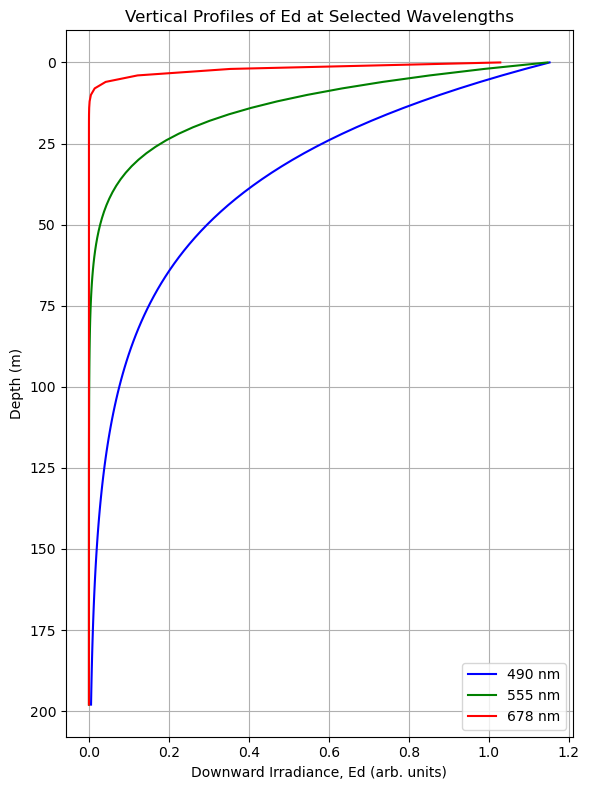

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define target wavelengths
wavelengths_target = [490.0, 555.0, 678.0]

# Select Kd values at target wavelengths
Kd_sel = Kd_pixel.sel(wavelength=wavelengths_target, method="nearest")

# Match Es values from df_es
Es_sel = df_es.set_index('wave').loc[[round(w) for w in Kd_sel['wavelength'].values], 'Es'].values

# Create depth array
depths = np.arange(0, 200, 2)

# Compute Ed profiles
Ed_profiles = [E0 * np.exp(-Kd_val * depths) for E0, Kd_val in zip(Es_sel, Kd_sel.values)]

# Plot
colors = ['b', 'g', 'r']
labels = [f"{wl:.0f} nm" for wl in Kd_sel['wavelength'].values]

plt.figure(figsize=(6, 8))
for Ed, label, color in zip(Ed_profiles, labels, colors):
    plt.plot(Ed, depths, f'-{color}', label=label)

plt.gca().invert_yaxis()
plt.xlabel("Downward Irradiance, Ed (arb. units)")
plt.ylabel("Depth (m)")
plt.title("Vertical Profiles of Ed at Selected Wavelengths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


What we can see here is that attenuation rates are not very steep for blue light, meaning blue light goes pretty far into the water column. This is a good indicator that we're dealing with open ocean waters. An honorable mention to green light, of course, who made it down about 75 meters before disappearing. Way to go green, we're all rooting for you. Then there's red. What are you doing red? Well, it turns out that even in the absence of a lot of absorbing and scattering particles, the very nature of pure water means it is going to absorb red light pretty quickly, so it left the party a bit early. 

## Let's look at this another way

Since we've got all this cool extra information from PACE, let's go ahead and make sure we get use out of those additional wavelengths. In the case below, we'll look at the whole spectrum of downwelling irradiance that we've calculated, and examine how it changes over some nominal depth intervals. 

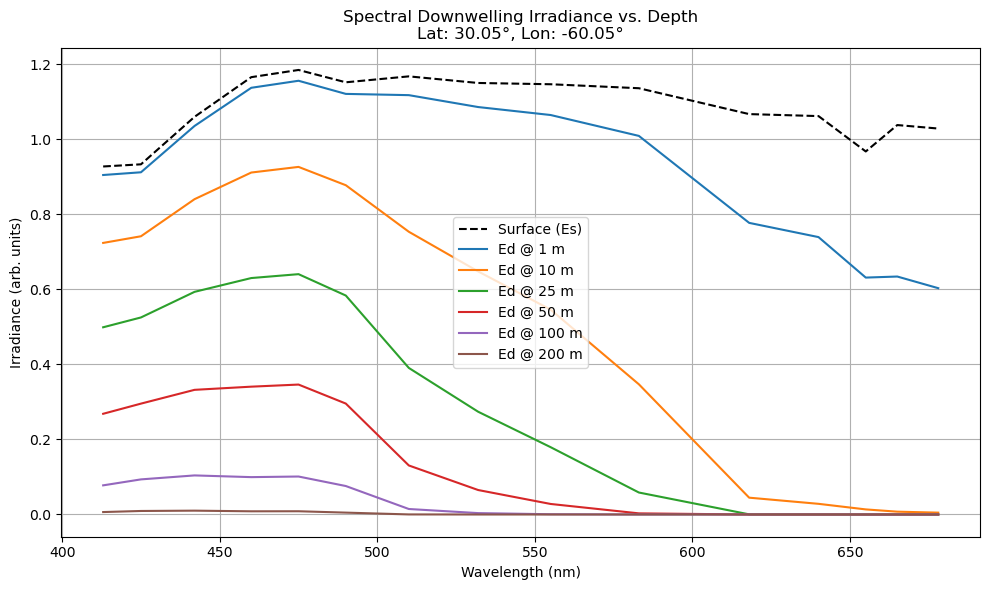

In [13]:
# Plot for all wavelengths at the target lat/lon
wavelengths_vals = Kd_pixel['wavelength'].values
Kd_vals = Kd_pixel.values

# Round wavelengths
waves_rounded = [round(w) for w in wavelengths_vals]

# Build a Series indexed by wave
es_by_wave = df_es.set_index('wave')['Es']

# Use reindex so missing wavelengths become NaN
Es_vals = es_by_wave.reindex(waves_rounded).values

# Define depths and compute attenuated spectra
depths = [1, 10, 25, 50, 100, 200]
attenuated_spectra = {
    z: Es_vals * np.exp(-Kd_vals * z) for z in depths
}

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths_vals, Es_vals, 'k--', label='Surface (Es)')

for z in depths:
    plt.plot(wavelengths_vals, attenuated_spectra[z], label=f'Ed @ {z} m')

# Extract selected lat/lon for title
lat_val = float(Kd_pixel['lat'].values)
lon_val = float(Kd_pixel['lon'].values)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance (arb. units)")
plt.title(f"Spectral Downwelling Irradiance vs. Depth\nLat: {lat_val:.2f}°, Lon: {lon_val:.2f}°")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

You can clearly see the anti-social red light absolutely refusing to join its friends into the deep. As such, the deeper you go, other wavelengths of light eventually attenuate as well, creating a dominance of blue light into the depths. This is the case for the open ocean. For fun, feel free to go back and put in some different coordinates, perhaps closer to the coast. A very different pattern will emerge here, as we'll illustrate below.  

## Let's paint the town rainbow!

Let's try a more integrated approach, so we can really see what is happening to the light with depth. We're going to extract two points - our open ocean example we used above, and then a point near the productive waters in the Patagonian shelf upwelling system. These points were shown in the first Kd figure. Doing a lot of the things we did earlier in the tutorial, we're going to restructure the data a tiny bit, so we get a higher (depth) resolution profile. In this instance, we'll generate an $E_{d}({\lambda},z)$ spectrum every 2 meters, over 100 meters of depth. After stacking this, we'll plot it more like a cross-section of light, illustrating the 4D nature of the PACE $K_{d}({\lambda})$ products.

## Let's make a plot!

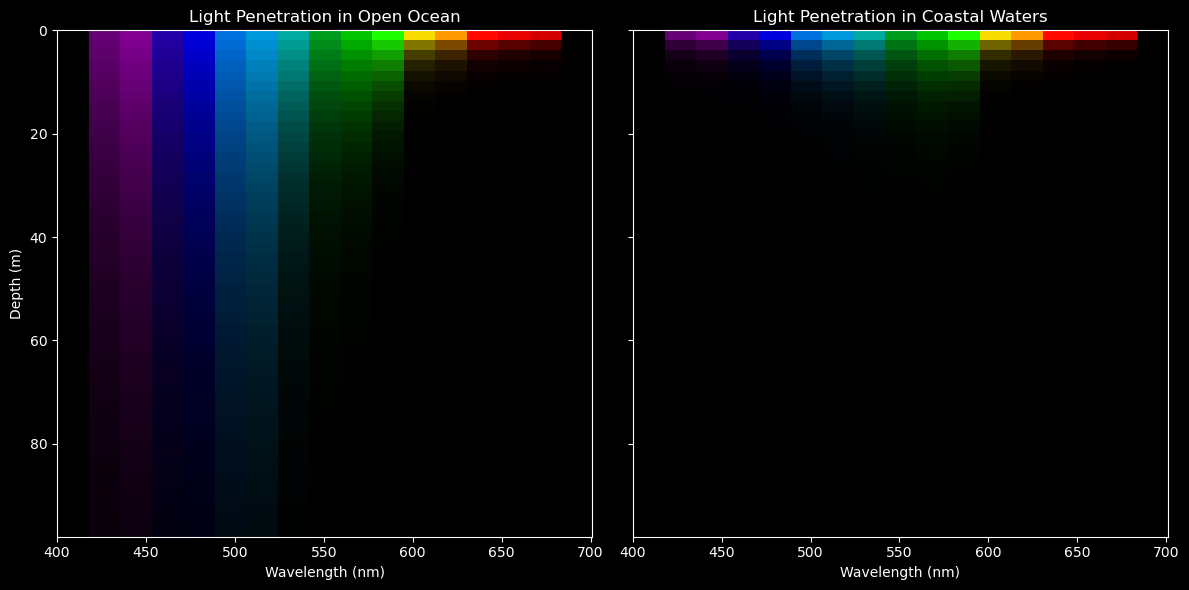

In [14]:
from matplotlib.colors import Normalize
import numpy as np
import matplotlib.pyplot as plt

# Define coordinate targets
open_coord = {'lat': 30.0, 'lon': -60.0}
coastal_coord = {'lat': -45.0, 'lon': -60.0}

# Select pixels using xarray's nearest neighbor method
Kd_open = Kd.sel(**open_coord, method="nearest")
Kd_coastal = Kd.sel(**coastal_coord, method="nearest")

# Extract wavelengths and Kd values
wavelengths_vals = Kd_open['wavelength'].values
Kd_vals_open = Kd_open.values
Kd_vals_coastal = Kd_coastal.values

# Get es_vals for the wavelengths
waves_rounded = np.round(wavelengths_vals).astype(int)
es_by_wave = df_es.set_index('wave')['Es'] # Series indexed by wave
# Use reindex so any missing waves become NaN
Es_vals = es_by_wave.reindex(waves_rounded).to_numpy()

# Create depth array
depths = np.arange(0, 100, 2)

# Compute attenuated spectra (shape: [depth, wavelength])
attenuated_spectra_open = np.array([Es_vals * np.exp(-Kd_vals_open * z) for z in depths])
attenuated_spectra_coastal = np.array([Es_vals * np.exp(-Kd_vals_coastal * z) for z in depths])

# Normalize for visualization
norm = Normalize(vmin=wavelengths_vals.min(), vmax=wavelengths_vals.max())
rgb_colors = plt.colormaps['nipy_spectral'](norm(wavelengths_vals))[:, :3]

open_norm = attenuated_spectra_open / attenuated_spectra_open[0, :]
coastal_norm = attenuated_spectra_coastal / attenuated_spectra_coastal[0, :]
open_norm[open_norm < 1e-3] = np.nan
coastal_norm[coastal_norm < 1e-3] = np.nan

# Convert to RGB image
def spectra_to_rgb(spectra, rgb_colors):
    return spectra[..., np.newaxis] * rgb_colors[np.newaxis, :, :]

rgb_open = spectra_to_rgb(open_norm, rgb_colors)
rgb_coastal = spectra_to_rgb(coastal_norm, rgb_colors)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for ax in axs:
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')

fig.patch.set_facecolor('black')

for ax, rgb_img, title in zip(axs, [rgb_open, rgb_coastal], ["Open Ocean", "Coastal Waters"]):
    ax.imshow(rgb_img, aspect='auto',
              extent=[wavelengths_vals.min(), wavelengths_vals.max(), depths.max(), depths.min()])
    ax.set_title(f"Light Penetration in {title}")
    ax.set_xlabel("Wavelength (nm)")

axs[0].set_ylabel("Depth (m)")
plt.tight_layout()
plt.show()


Notice how the blue light didn't go down very far in the "Coastal Waters"? The reason for this is that greedy little phytoplankton are preferentially absorbing this blue light to fuel photosynthesis. We think of algae as green plants, but what we're seeing here is that they appear inherently green to our eyes only because they are utilizing all the other wavelengths of light except for green! Other things can absorb blue light as well, like chromophoric dissolved organic matter and detritus, further changing the differential attenuation rates. Now, attenuation doesn't just mean absorption of light. Light is also being scattered, perhaps multiple times. Particles can scatter light back out of the water and prevent it from going deeper, which also contributes to attenuation. Depending on the size and shape of that particle, it may be that it helps the light scatter multiple times, thereby increasing its chance of being absorbed on the way back up! While we're only seeing a surface reflectance value from space, it represents a complex series of physical processes with light and the environment beneath the surface. 

There you have it! Spectral light attenuation of downwelling irradiance. Now you have the ability to quantitatively characterize the subsurface light field for any depth across the entire ocean. Go PACE!

## Let's do time!

So far we have just looked at one month. Let's look at all the months and see how light attenuation has changed over months in our coastal point. We have 13 months of data.

In [15]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [16]:
results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_KD",
    granule_name="*.MO.*.0p1deg.*"
)
len(results)

19

In [17]:
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/19 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/19 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/19 [00:00<?, ?it/s]

In [19]:
# This step requires > 2 Gb RAM
import xarray as xr
ds_month = xr.open_mfdataset(fileset, combine='nested', concat_dim='time')

In [20]:
# the netcdfs do not have time so we need to get that from the results metadata
# Use the beginning of each 8-day window as the time coordinate
import numpy as np
time = [
    np.datetime64(r["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"][:10])
    for r in results
]

# Assign time coordinate
ds_month = ds_month.assign_coords(time=("time", time))
ds_month

<xarray.Dataset> Size: 8GB
Dimensions:     (time: 19, lat: 1800, lon: 3600, wavelength: 17, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 136B 400.0 413.0 425.0 ... 678.0 701.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
  * time        (time) datetime64[s] 152B 2024-03-05 2024-04-01 ... 2025-09-01
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Kd          (time, lat, lon, wavelength) float32 8GB dask.array<chunksize=(1, 16, 1024, 8), meta=np.ndarray>
    palette     (time, rgb, eightbitcolor) uint8 15kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.KD.V...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/KD/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3314638
    data_minimum:                      0.0052
    data_maximum:                      5.9724836

For the first plot, we will look at Ed over time at 3 wavelengths.

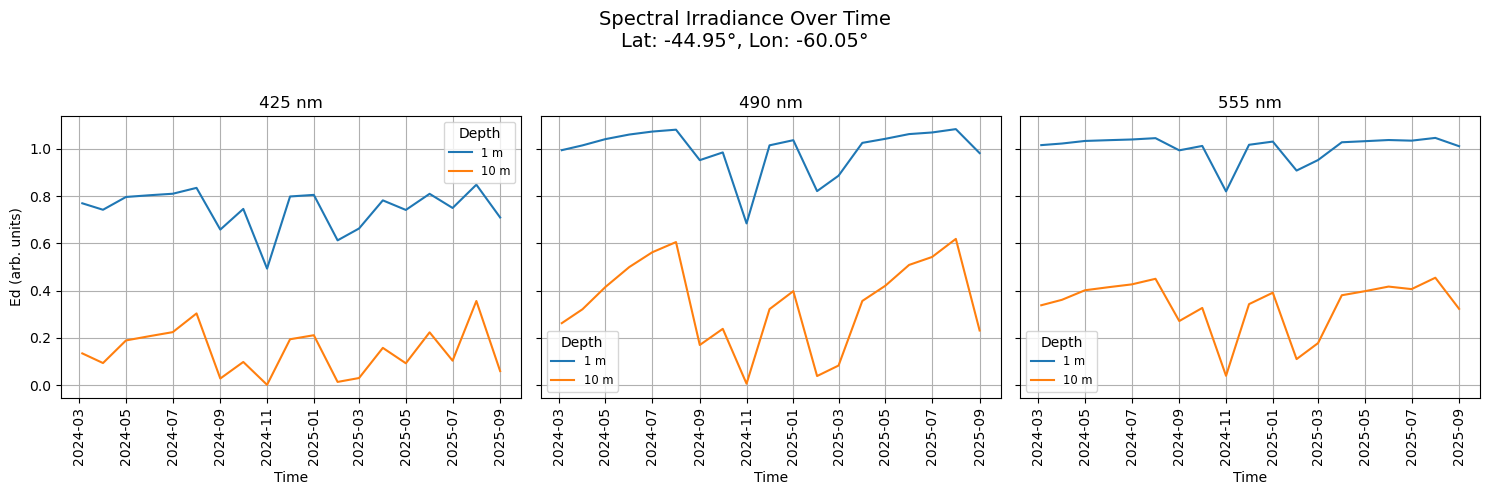

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load Es
from io import StringIO
df_es = pd.read_csv(StringIO("wave,Es\n351,0.43348\n361,0.43439\n385,0.47793\n413,0.92794\n425,0.93371\n442,1.0603\n460,1.1661\n475,1.1853\n490,1.1524\n510,1.1682\n532,1.1506\n555,1.1472\n583,1.1366\n618,1.0676\n640,1.0623\n655,0.96797\n665,1.0384\n678,1.0291\n711,0.96479"))

# Target lat/lon and wavelengths
target_lat = -45.0
target_lon = -60.0
wavelengths_target = [420.0, 490.0, 555.0]
depths = [1, 10]

# Select Kd(time, wavelength) at pixel
Kd_pixel = ds_month['Kd'].sel(lat=target_lat, lon=target_lon, method="nearest")
Kd_sel = Kd_pixel.sel(wavelength=wavelengths_target, method="nearest")  # shape: (time, wavelength)

# Match Es values
actual_wavelengths = Kd_sel['wavelength'].values
Es_vals = df_es.set_index('wave').loc[[round(w) for w in actual_wavelengths], 'Es'].values

# Time
time_vals = pd.to_datetime(ds_month['time'].values)

# Compute Ed(time, depth, wavelength)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, (ax, wl, E0) in enumerate(zip(axs, actual_wavelengths, Es_vals)):
    Kd_wl = Kd_sel.isel(wavelength=i).values  # (time,)
    for z in depths:
        Ed_time = E0 * np.exp(-Kd_wl * z)
        ax.plot(time_vals, Ed_time, label=f"{z} m")
    
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(f"{int(wl)} nm")
    ax.set_xlabel("Time")
    if i == 0:
        ax.set_ylabel("Ed (arb. units)")
    ax.grid(True)
    ax.legend(title="Depth", fontsize='small')

# Annotate
lat_val = float(Kd_sel['lat'].values)
lon_val = float(Kd_sel['lon'].values)
fig.suptitle(f"Spectral Irradiance Over Time\nLat: {lat_val:.2f}°, Lon: {lon_val:.2f}°", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


For the second plot we will look at Ed at 10m for all wavelengths. The light attenuation varies by month.

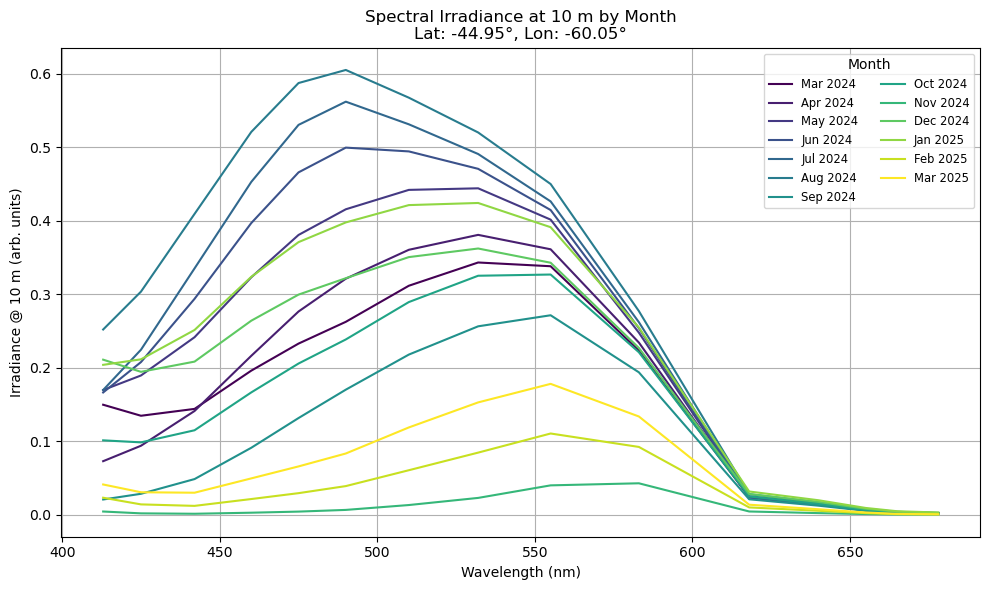

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Load Es
from io import StringIO
df_es = pd.read_csv(StringIO("wave,Es\n351,0.43348\n361,0.43439\n385,0.47793\n413,0.92794\n425,0.93371\n442,1.0603\n460,1.1661\n475,1.1853\n490,1.1524\n510,1.1682\n532,1.1506\n555,1.1472\n583,1.1366\n618,1.0676\n640,1.0623\n655,0.96797\n665,1.0384\n678,1.0291\n711,0.96479"))

# Target coastal location and depth
target_lat = -45.0
target_lon = -60.0
z = 10  # depth in meters

# Select Kd(time, wavelength) at nearest lat/lon
Kd_pixel = ds_month['Kd'].sel(lat=target_lat, lon=target_lon, method="nearest")
wavelengths_vals = Kd_pixel['wavelength'].values
Kd_vals = Kd_pixel.values  # shape: (time, wavelength)

# Match Es using rounded wavelengths
waves_rounded = np.round(wavelengths_vals).astype(int)
es_by_wave = df_es.set_index('wave')['Es'] # Series indexed by wave
# Use reindex so any missing waves become NaN
Es_vals = es_by_wave.reindex(waves_rounded).to_numpy()

# Compute Ed at 10 m
Ed_10m = Es_vals * np.exp(-Kd_vals * z)

# Time labels
time_labels = pd.date_range("2024-03", periods=13, freq="MS").strftime('%b %Y')

# Define a colormap across time steps
cmap = plt.colormaps.get_cmap('viridis')
colors = [cmap(i / (len(time_labels) - 1)) for i in range(len(time_labels))]

# Plot
plt.figure(figsize=(10, 6))
for i, (label, color) in enumerate(zip(time_labels, colors)):
    plt.plot(wavelengths_vals, Ed_10m[i], label=label, color=color)

# Annotations
lat_val = float(Kd_pixel['lat'].values)
lon_val = float(Kd_pixel['lon'].values)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance @ 10 m (arb. units)")
plt.title(f"Spectral Irradiance at 10 m by Month\nLat: {lat_val:.2f}°, Lon: {lon_val:.2f}°")
plt.grid(True)
plt.legend(loc='upper right', ncol=2, fontsize='small', title="Month")
plt.tight_layout()
plt.show()


## Summary

Hopefully this notebook has gotten you excited about the possibilities of using light availability as information for understanding the ocean environment.